In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Deep learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
from scipy.stats import pearsonr, spearmanr
import os
import matplotlib.cm as cm

2025-05-09 13:29:03.561887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 13:29:04.441279: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 13:29:05.079403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746822545.305325 2468384 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746822545.803691 2468384 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746822547.349567 2468384 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
# # Function to calculate reconstruction MSE
# def calculate_mse(model, electron_features, photon_features, vertices):
#     vertices = vertices.reshape(vertices.shape[0], 1, vertices.shape[1])
#     # Prepare inputs
#     inputs = {
#         'electron_input': electron_features,
#         'photon_input': photon_features,
#         'vertex_input': vertices
#     }
    
#     # Get model predictions
#     predictions = model.predict(inputs, batch_size=2048)
    
#     # Calculate MSE for electrons
#     electron_mse = np.mean(
#         np.square(predictions['electron_output'] - electron_features),
#         axis=(1, 2)  # Reduce over particle and feature dimensions
#     )
    
#     # Calculate MSE for photons
#     photon_mse = np.mean(
#         np.square(predictions['photon_output'] - photon_features),
#         axis=(1, 2)  # Reduce over particle and feature dimensions
#     )
    
#     # Total MSE (average of electron and photon MSEs)
#     total_mse = (electron_mse + photon_mse) / 2
    
#     return total_mse

In [ ]:
# # Function to calculate reconstruction MAE
# def calculate_mae(model, electron_features, photon_features, vertices):
#     vertices = vertices.reshape(vertices.shape[0], 1, vertices.shape[1])
#     # Prepare inputs
#     inputs = {
#         'electron_input': electron_features,
#         'photon_input': photon_features,
#         'vertex_input': vertices
#     }
    
#     # Get model predictions
#     predictions = model.predict(inputs, batch_size=2048)
    
#     # Calculate MAE for electrons
#     electron_mae = np.mean(
#         np.absolute(predictions['electron_output'] - electron_features),
#         axis=(1, 2)  # Reduce over particle and feature dimensions
#     )
    
#     # Calculate MAE for photons
#     photon_mae = np.mean(
#         np.square(predictions['photon_output'] - photon_features),
#         axis=(1, 2)  # Reduce over particle and feature dimensions
#     )
    
#     # Total MAE (average of electron and photon MAEs)
#     total_mae = (electron_mae + photon_mae) / 2
    
#     return total_mae

In [2]:
def calculate_tanh_error(model, electron_features, photon_features, vertices):
    vertices = vertices.reshape(vertices.shape[0], 1, vertices.shape[1])
    
    # Prepare inputs
    inputs = {
        'electron_input': electron_features,
        'photon_input': photon_features,
        'vertex_input': vertices
    }
    
    # Get model predictions
    predictions = model.predict(inputs, batch_size=2048)
    
    # Calculate sigmoid of error for electrons
    electron_error = predictions['electron_output'] - electron_features
    electron_squared_error = np.square(electron_error)
    electron_squared_tanh_error = np.tanh(electron_squared_error)
    
    electron_mean_squared_tanh = np.mean(
        electron_squared_tanh_error,
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Calculate sigmoid of error for photons
    photon_error = predictions['photon_output'] - photon_features
    photon_tanh_error = np.tanh(photon_error)
    photon_squared_tanh_error = np.square(photon_tanh_error)
    photon_mean_squared_tanh = np.mean(
        photon_squared_tanh_error,
        axis=(1, 2)  # Reduce over particle and feature dimensions
    )
    
    # Total mean of squared sigmoid of error (average of electron and photon values)
    total_mean_squared_tanh = (electron_mean_squared_tanh + photon_mean_squared_tanh) / 2
    
    return total_mean_squared_tanh

In [3]:
# constants: transformed “all–zero” particle
EMPTY_ELECTRON = np.array([
    -3.74531232e-01, -9.02301235e-03, -1.82138801e-06,  0.,
     0.,  0.,  0., -3.40324104e-01, -1.86411055e-01,
    -3.74529962e-01, -3.52771470e-01, -2.17548504e-01,  1.68711789e-04
], dtype=np.float32)

EMPTY_PHOTON = np.array([
    -7.93930453e-01, -6.22533163e-05, -2.65618571e-07,  0.,
    -3.84318226e-01, -7.16487544e-01, -3.47047918e-01, -7.88056580e-01,
    -7.86572037e-01,  1.22903633e-03,  2.37914691e-03,  3.72620130e-04
], dtype=np.float32)
EMPTY_E = tf.constant(EMPTY_ELECTRON, dtype=tf.float32)   # (13,)
EMPTY_P = tf.constant(EMPTY_PHOTON , dtype=tf.float32)    # (12,)

2025-05-09 13:30:38.819556: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Load data
# max_events = 100000
print("Loading test data...")
test_electron_features = np.load('test_data_e.npy')#[:max_events]
test_photon_features = np.load('test_data_p.npy')#[:max_events]
test_vertices = np.load('test_data_v.npy')#[:max_events]

print("Loading signal data...")
signal_electron_features = np.load('output_model_directory/signal_data_e_v3.npy')
signal_photon_features = np.load('output_model_directory/signal_data_p_v3.npy')
signal_vertices = np.load('output_model_directory/signal_data_v_v3.npy')
signal_models = np.load('output_model_directory/signal_models_v3.npy')
signal_job_ids = np.load('output_model_directory/signal_job_ids_v3.npy')

print(f"Test data shapes: electrons {test_electron_features.shape}, photons {test_photon_features.shape}, vertices {test_vertices.shape}")
print(f"Signal data shapes: electrons {signal_electron_features.shape}, photons {signal_photon_features.shape}, vertices {signal_vertices.shape}")
print(f"Signal models shape: {signal_models.shape}")
print(f"Unique signal models: {np.unique(signal_models)}")

Loading test data...
Loading signal data...
Test data shapes: electrons (485593, 4, 13), photons (485593, 4, 12), vertices (485593, 3)
Signal data shapes: electrons (2080280, 4, 13), photons (2080280, 4, 12), vertices (2080280, 3)
Signal models shape: (2080280,)
Unique signal models: ['110_30_0p1ns' '110_30_0p5ns' '110_30_10ns' '110_30_2ns' '200_10_0p1ns'
 '200_10_10ns' '200_10_2ns' '200_15_0p5ns' '200_15_10ns' '200_15_2ns'
 '200_50_10ns' '200_50_2ns' '200_90_0p1ns' '200_90_0p5ns' '200_90_10ns'
 '200_90_2ns' '400_100_0p1ns' '400_100_0p5ns' '400_100_10ns' '400_100_2ns'
 '400_10_0p1ns' '400_10_0p5ns' '400_10_10ns' '400_15_0p1ns' '400_15_0p5ns'
 '400_15_10ns' '400_190_0p1ns' '400_190_0p5ns' '400_190_10ns'
 '600_10_0p1ns' '600_10_10ns' '600_10_2ns' '600_150_0p1ns' '600_150_0p5ns'
 '600_150_10ns' '600_150_2ns' '600_15_0p1ns' '600_15_0p5ns' '600_15_10ns'
 '600_15_2ns' '600_290_0p1ns' '600_290_0p5ns' '600_290_10ns' '600_290_2ns'
 '60_25_0p5ns' '60_25_10ns' '60_25_2ns']


In [5]:
print(test_electron_features.shape)

(485593, 4, 13)


In [6]:
def create_embedding_network(input_dim, hidden_dim, output_dim):
    """Create a deep embedding network."""
    return keras.Sequential([
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(output_dim)
    ])

class TransformerEncoderBlock(layers.Layer):
    """Transformer encoder block with multi-head attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def call(self, inputs):
        attention_output = self.attention(query=inputs, key=inputs, value=inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecoderBlock(layers.Layer):
    """Transformer decoder block with multi-head self and cross attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.self_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.cross_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)
        
    def call(self, inputs, encoder_outputs):
        # Self attention
        self_attention_output = self.self_attention(
            query=inputs,
            key=inputs,
            value=inputs
        )
        self_attention_output = self.dropout1(self_attention_output)
        out1 = self.layernorm1(inputs + self_attention_output)
        
        # Cross attention with encoder outputs
        cross_attention_output = self.cross_attention(
            query=out1,
            key=encoder_outputs,
            value=encoder_outputs
        )
        cross_attention_output = self.dropout2(cross_attention_output)
        out2 = self.layernorm2(out1 + cross_attention_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.layernorm3(out2 + ffn_output)

In [7]:
electron_features_list = [
    'electron_pt', 'electron_eta', 'electron_phi',
    'electron_time',
    'electron_d0', 'electron_z0', 'electron_dpt',
    'electron_nPIX', 'electron_nMissingLayers',
    'electron_chi2',
    'electron_f1', 'electron_f3', 'electron_z'
]

photon_features_list = [
    'photon_pt', 'photon_eta', 'photon_phi',
    'photon_time',
    'photon_maxEcell_E',
    'photon_f1', 'photon_f3', 'photon_r1', 'photon_r2',
    'photon_etas1', 'photon_phis1', 'photon_z'
]

In [8]:
class ParticleTransformer(keras.Model):
    """Complete transformer model for particle physics data."""
    def __init__(
        self,
        max_electrons=4,
        max_photons=4,
        electron_embedding_dim=13,
        photon_embedding_dim=12,
        vertex_embedding_dim=3,
        common_embedding_dim=8,
        num_encoder_layers=4,
        num_decoder_layers=4,
        num_heads=4
    ):
        super().__init__()
        
        # Input embeddings with different dimensions
        self.electron_embedding = create_embedding_network(
            len(electron_features_list),  # electron feature dim
            electron_embedding_dim,
            common_embedding_dim
        )
        self.photon_embedding = create_embedding_network(
            len(photon_features_list),  # photon feature dim
            photon_embedding_dim,
            common_embedding_dim
        )
        self.vertex_embedding = create_embedding_network(
            3,   # vertex feature dim
            vertex_embedding_dim,
            common_embedding_dim
        )
              
        # Transformer encoder layers
        self.encoder_layers = [
            TransformerEncoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_encoder_layers)
        ]
        
        # Transformer decoder layers
        self.decoder_layers = [
            TransformerDecoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_decoder_layers)
        ]
        
        # Output projection layers
        self.electron_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(electron_features_list))  # electron features
        ])
        self.photon_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(photon_features_list))  # photon features
        ])
        
    def encode_particles(self, electron_inputs, photon_inputs, vertex_inputs):
        # Embed particles
        e_embedded = self.electron_embedding(electron_inputs)
        p_embedded = self.photon_embedding(photon_inputs)
        v_embedded = self.vertex_embedding(vertex_inputs)
        
        # Combine embeddings
        combined = tf.concat([e_embedded, p_embedded, v_embedded], axis=1)
        
        # Pass through encoder layers
        encoded = combined
        intermediates = []
        for encoder_layer in self.encoder_layers:
            encoded = encoder_layer(encoded)
            intermediates.append(encoded)
            
        return encoded, intermediates
        
    def decode_particles(self, encoded, encoder_intermediates):
        decoded = encoded
        
        # Pass through decoder layers with corresponding encoder outputs
        for decoder_layer, encoder_output in zip(self.decoder_layers, encoder_intermediates):
            decoded = decoder_layer(decoded, encoder_output)
            
        return decoded
        
    def call(self, inputs):
        ei, pi, vi = inputs["electron_input"], inputs["photon_input"], inputs["vertex_input"]

        enc, enc_int = self.encode_particles(ei, pi, vi)
        dec          = self.decode_particles(enc, enc_int)

        e_len = tf.shape(ei)[1]
        p_len = tf.shape(pi)[1]

        e_dec = dec[:, :e_len]
        p_dec = dec[:, e_len:e_len + p_len]

        # reconstruction
        e_out = self.electron_reconstruction(e_dec)           # (B, e_len, 13)
        p_out = self.photon_reconstruction(p_dec)             # (B, p_len, 12)

        # masks: True where the *input* is exactly the EMPTY_* vector
        e_mask = tf.reduce_all(tf.equal(ei, EMPTY_E), axis=-1)        # (B, e_len)
        p_mask = tf.reduce_all(tf.equal(pi, EMPTY_P), axis=-1)        # (B, p_len)

        # broadcast masks and overwrite outputs
        e_out = tf.where(e_mask[..., None], EMPTY_E, e_out)
        p_out = tf.where(p_mask[..., None], EMPTY_P, p_out)

        return {"electron_output": e_out, "photon_output": p_out}

In [9]:
class ParticleDataGenerator(keras.utils.Sequence):
    """Data generator for particle physics events."""
    def __init__(self, data, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.electron_data, self.photon_data, self.vertex_data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.vertex_data))
        self.on_epoch_end()
        
    def __len__(self):
        """Number of batches per epoch."""
        return len(self.indices) // self.batch_size
        
    def on_epoch_end(self):
        """Called at the end of every epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):
        """Get one batch of data."""
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Prepare batch data
        x = {
            'electron_input': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_input': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32),
            'vertex_input': tf.convert_to_tensor(self.vertex_data[batch_indices, np.newaxis, :], dtype=tf.float32)
        }
        
        y = {
            'electron_output': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_output': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32)
        }
        
        return x, y


In [10]:
electron_in = keras.Input((4, len(electron_features_list)), name="electron_input")
photon_in   = keras.Input((4, len(photon_features_list)),  name="photon_input")
vertex_in   = keras.Input((1, 3),                          name="vertex_input")

core = ParticleTransformer(
        max_electrons=4, max_photons=4,
        electron_embedding_dim=13, photon_embedding_dim=12,
        vertex_embedding_dim=3, common_embedding_dim=8,
        num_encoder_layers=4, num_decoder_layers=4, num_heads=4)

outputs = core({
    "electron_input": electron_in,
    "photon_input":  photon_in,
    "vertex_input":  vertex_in})

model = keras.Model(inputs=[electron_in, photon_in, vertex_in], outputs=outputs)
model.load_weights("particle_transformer_v3.keras")

In [11]:
print(signal_electron_features[0])

[[-3.74531232e-01 -9.02301235e-03 -1.82138801e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.40324104e-01
  -1.86411055e-01 -3.74529962e-01 -3.52771470e-01 -2.17548504e-01
   1.68711789e-04]
 [-3.74531232e-01 -9.02301235e-03 -1.82138801e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.40324104e-01
  -1.86411055e-01 -3.74529962e-01 -3.52771470e-01 -2.17548504e-01
   1.68711789e-04]
 [-3.74531232e-01 -9.02301235e-03 -1.82138801e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.40324104e-01
  -1.86411055e-01 -3.74529962e-01 -3.52771470e-01 -2.17548504e-01
   1.68711789e-04]
 [-3.74531232e-01 -9.02301235e-03 -1.82138801e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.40324104e-01
  -1.86411055e-01 -3.74529962e-01 -3.52771470e-01 -2.17548504e-01
   1.68711789e-04]]


In [12]:
# Calculate anomaly scores
print("Calculating test data anomaly scores...")
test_scores = calculate_tanh_error(model, test_electron_features, test_photon_features, test_vertices)

print("Calculating signal data anomaly scores...")
signal_scores = calculate_tanh_error(model, signal_electron_features, signal_photon_features, signal_vertices)

# Create labels (0 for test/background, 1 for signal)
test_labels = np.zeros(len(test_scores))
signal_labels = np.ones(len(signal_scores))

# Combine scores and labels 
all_scores = np.concatenate([test_scores, signal_scores])
all_labels = np.concatenate([test_labels, signal_labels])

# Calculate overall ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

print(f"Overall ROC AUC: {roc_auc:.6f}")

Calculating test data anomaly scores...
238/238 ━━━━━━━━━━━━━━━━━━━━ 198s 807ms/step
Calculating signal data anomaly scores...
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 734s 721ms/step
Overall ROC AUC: 0.911762


In [21]:
def display_highest_score_events(model, e_feats, p_feats, vertices, scores, n_events=2, dataset_name="Dataset"):
    """
    Display the highest-scoring events from a dataset with detailed error analysis.
    Shows both raw differences and tanh(diff²) for each feature with feature names.
    """
    # Define feature names
    electron_features_list = [
        'electron_pt', 'electron_eta', 'electron_phi',
        'electron_time', 'electron_d0', 'electron_z0', 'electron_dpt',
        'electron_nPIX', 'electron_nMissingLayers', 
        'electron_chi2', 'electron_numberDoF', 'electron_f1', 'electron_f3', 'electron_z'
    ]
    
    photon_features_list = [
        'photon_pt', 'photon_eta', 'photon_phi',
        'photon_time', 'photon_maxEcell_E', 'photon_f1', 'photon_f3', 
        'photon_r1', 'photon_r2', 'photon_etas1', 'photon_phis1', 'photon_z'
    ]
    
    # Find indices of highest scoring events
    top_indices = np.argsort(scores)[-n_events:][::-1]
    
    print(f"\n===== Top {n_events} highest scoring events from {dataset_name} =====")
    
    for i, idx in enumerate(top_indices):
        # Get input features for this event
        electron_input = e_feats[idx:idx+1]
        photon_input = p_feats[idx:idx+1]
        
        # Handle vertex input - reshape if necessary
        vertex_input = vertices[idx:idx+1]
        if len(vertex_input.shape) == 2:
            vertex_input = vertex_input.reshape(vertex_input.shape[0], 1, vertex_input.shape[1])
        
        # Get model prediction
        inputs = {
            'electron_input': electron_input,
            'photon_input': photon_input,
            'vertex_input': vertex_input
        }
        prediction = model.predict(inputs, verbose=0)
        
        # Print event information
        print(f"\nEvent {i+1} (index {idx}): Score = {scores[idx]:.6f}")
        
        # Print basic event properties
        if vertex_input.shape[1] == 1:
            print(f"  Vertex position: {vertex_input[0, 0]}")
        
        # Count total particles
        n_electrons = 4
        n_photons = 4
        print(f"  Number of electrons: {n_electrons}")
        print(f"  Number of photons: {n_photons}")
        
        # Print features of all particles with comparisons
        print("\n  ELECTRONS (actual vs predicted):")
        all_electron_errors = []
        
        for e_idx in range(4):
            print(f"  Electron #{e_idx+1}:")
            
            # Calculate tanh errors for this electron
            e_tanh_errors = []
            e_feature_errors = {}  # Store errors by feature name
            
            for feat_idx in range(min(len(electron_features_list), electron_input.shape[2])):
                feat_name = electron_features_list[feat_idx]
                actual = electron_input[0, e_idx, feat_idx]
                pred = prediction['electron_output'][0, e_idx, feat_idx]
                diff = actual - pred
                diff_squared = diff**2
                tanh_diff_squared = np.tanh(diff_squared)
                
                e_tanh_errors.append(tanh_diff_squared)
                e_feature_errors[feat_name] = tanh_diff_squared
                
                # Print feature details
                print(f"    {feat_name}: {actual:.4f} vs {pred:.4f} (diff: {diff:.4f}, tanh(diff²): {tanh_diff_squared:.4f})")
            
            # Add individual errors to the flat list
            all_electron_errors.extend(e_tanh_errors)
            
            # Find and print top 3 error features
            top_error_features = sorted(e_feature_errors.items(), key=lambda x: x[1], reverse=True)[:3]
            print(f"    Mean tanh(diff²) for this electron: {np.mean(e_tanh_errors):.4f}")
            print(f"    Top error features: " + ", ".join([f"{name} ({val:.4f})" for name, val in top_error_features]))
            print("")
        
        # Calculate overall electron error
        if all_electron_errors:
            avg_electron_error = np.mean(all_electron_errors)
            print(f"  Overall mean electron tanh(diff²): {avg_electron_error:.4f}")
        
        print("\n  PHOTONS (actual vs predicted):")
        all_photon_errors = []
        
        for p_idx in range(4):
            print(f"  Photon #{p_idx+1}:")
            
            # Calculate tanh errors for this photon
            p_tanh_errors = []
            p_feature_errors = {}  # Store errors by feature name
            
            for feat_idx in range(min(len(photon_features_list), photon_input.shape[2])):
                feat_name = photon_features_list[feat_idx]
                actual = photon_input[0, p_idx, feat_idx]
                pred = prediction['photon_output'][0, p_idx, feat_idx]
                diff = actual - pred
                diff_squared = diff**2
                tanh_diff_squared = np.tanh(diff_squared)
                
                p_tanh_errors.append(tanh_diff_squared)
                p_feature_errors[feat_name] = tanh_diff_squared
                
                # Print feature details
                print(f"    {feat_name}: {actual:.4f} vs {pred:.4f} (diff: {diff:.4f}, tanh(diff²): {tanh_diff_squared:.4f})")
            
            # Add individual errors to the flat list
            all_photon_errors.extend(p_tanh_errors)
            
            # Find and print top 3 error features
            top_error_features = sorted(p_feature_errors.items(), key=lambda x: x[1], reverse=True)[:3]
            print(f"    Mean tanh(diff²) for this photon: {np.mean(p_tanh_errors):.4f}")
            print(f"    Top error features: " + ", ".join([f"{name} ({val:.4f})" for name, val in top_error_features]))
            print("")
        
        # Calculate overall photon error
        if all_photon_errors:
            avg_photon_error = np.mean(all_photon_errors)
            print(f"  Overall mean photon tanh(diff²): {avg_photon_error:.4f}")
        
        # Calculate and print total event error
        all_errors = all_electron_errors + all_photon_errors
        if all_errors:
            total_avg_error = np.mean(all_errors)
            print(f"\n  Total event mean tanh(diff²): {total_avg_error:.4f}")
            print(f"  Compare with event score: {scores[idx]:.6f}")

In [22]:
# Usage:
# Display highest scoring background events
background_indices = np.where(all_labels == 0)[0]
background_only_scores = all_scores[background_indices]
display_highest_score_events(
    model,
    test_electron_features,
    test_photon_features,
    test_vertices,
    background_only_scores,
    n_events=3,
    dataset_name="Background"
)


===== Top 3 highest scoring events from Background =====

Event 1 (index 335700): Score = 0.615249
  Vertex position: [ 0.8010208  -0.11249762 -0.07687164]
  Number of electrons: 4
  Number of photons: 4

  ELECTRONS (actual vs predicted):
  Electron #1:
    electron_pt: -0.3745 vs -0.3707 (diff: -0.0038, tanh(diff²): 0.0000)
    electron_eta: -0.0090 vs -0.0103 (diff: 0.0013, tanh(diff²): 0.0000)
    electron_phi: -0.0000 vs 0.0005 (diff: -0.0005, tanh(diff²): 0.0000)
    electron_time: 0.0000 vs -0.2240 (diff: 0.2240, tanh(diff²): 0.0502)
    electron_d0: 0.0000 vs -0.0005 (diff: 0.0005, tanh(diff²): 0.0000)
    electron_z0: 0.0000 vs -0.0502 (diff: 0.0502, tanh(diff²): 0.0025)
    electron_dpt: 0.0000 vs -0.0024 (diff: 0.0024, tanh(diff²): 0.0000)
    electron_nPIX: -0.3403 vs -0.3383 (diff: -0.0020, tanh(diff²): 0.0000)
    electron_nMissingLayers: -0.1864 vs -0.1869 (diff: 0.0004, tanh(diff²): 0.0000)
    electron_chi2: -0.3745 vs -0.3732 (diff: -0.0013, tanh(diff²): 0.0000)
    

In [13]:
# Create a dictionary to store per-model results
model_results = {}

# Get list of unique models
unique_models = np.roll(np.unique(signal_models), 3)
print(f"Analyzing {len(unique_models)} unique signal models...")

# Perform analysis for each model separately
for model_name in unique_models:
    # Get mask for this model
    model_mask = signal_models == model_name
    
    # Get scores for this model only
    model_scores = signal_scores[model_mask]
    
    # Create model-specific labels
    model_labels = np.ones(len(model_scores))
    
    # Combine with test data for ROC calculation
    model_all_scores = np.concatenate([test_scores, model_scores])
    model_all_labels = np.concatenate([test_labels, model_labels])
    
    # Calculate model-specific ROC
    model_fpr, model_tpr, model_thresholds = roc_curve(model_all_labels, model_all_scores)
    model_roc_auc = auc(model_fpr, model_tpr)
    
    # Parse parameters from model name
    parts = model_name.split('_')
    mass1 = int(parts[0])
    mass2 = int(parts[1])
    
    # Handle lifetime format (convert 0p1ns to 0.1)
    lifetime_str = parts[2].replace('ns', '')
    lifetime = float(lifetime_str.replace('p', '.'))
    
    # Calculate statistics for this model
    model_results[model_name] = {
        'num_events': np.sum(model_mask),
        'mean_score': np.mean(model_scores),
        'scores': model_scores,
        'roc_auc': model_roc_auc,
        'mass1': mass1,
        'mass2': mass2,
        'lifetime': lifetime
    }
    
    print(f"Model {model_name}: {np.sum(model_mask)} events, ROC AUC = {model_roc_auc:.6f}")


Analyzing 47 unique signal models...
Model 60_25_0p5ns: 55057 events, ROC AUC = 0.953121
Model 60_25_10ns: 5340 events, ROC AUC = 0.724128
Model 60_25_2ns: 18774 events, ROC AUC = 0.831494
Model 110_30_0p1ns: 83352 events, ROC AUC = 0.995069
Model 110_30_0p5ns: 77710 events, ROC AUC = 0.940577
Model 110_30_10ns: 16744 events, ROC AUC = 0.655819
Model 110_30_2ns: 26963 events, ROC AUC = 0.792159
Model 200_10_0p1ns: 79792 events, ROC AUC = 0.946993
Model 200_10_10ns: 3367 events, ROC AUC = 0.553752
Model 200_10_2ns: 15817 events, ROC AUC = 0.609111
Model 200_15_0p5ns: 64946 events, ROC AUC = 0.809899
Model 200_15_10ns: 6487 events, ROC AUC = 0.539476
Model 200_15_2ns: 13917 events, ROC AUC = 0.621158
Model 200_50_10ns: 23953 events, ROC AUC = 0.641744
Model 200_50_2ns: 68060 events, ROC AUC = 0.804484
Model 200_90_0p1ns: 93391 events, ROC AUC = 0.998002
Model 200_90_0p5ns: 88904 events, ROC AUC = 0.978444
Model 200_90_10ns: 17922 events, ROC AUC = 0.762950
Model 200_90_2ns: 74156 events,

In [14]:
model_params = []
for model_name, results in model_results.items():
    model_params.append({
        'name': model_name,
        'mass1': results['mass1'],
        'mass2': results['mass2'],
        'lifetime': results['lifetime'],
        'roc_auc': results['roc_auc'],
        'mean_score': results['mean_score'],
        'num_events': results['num_events']
    })

# Convert to DataFrame for easier analysis
params_df = pd.DataFrame(model_params)

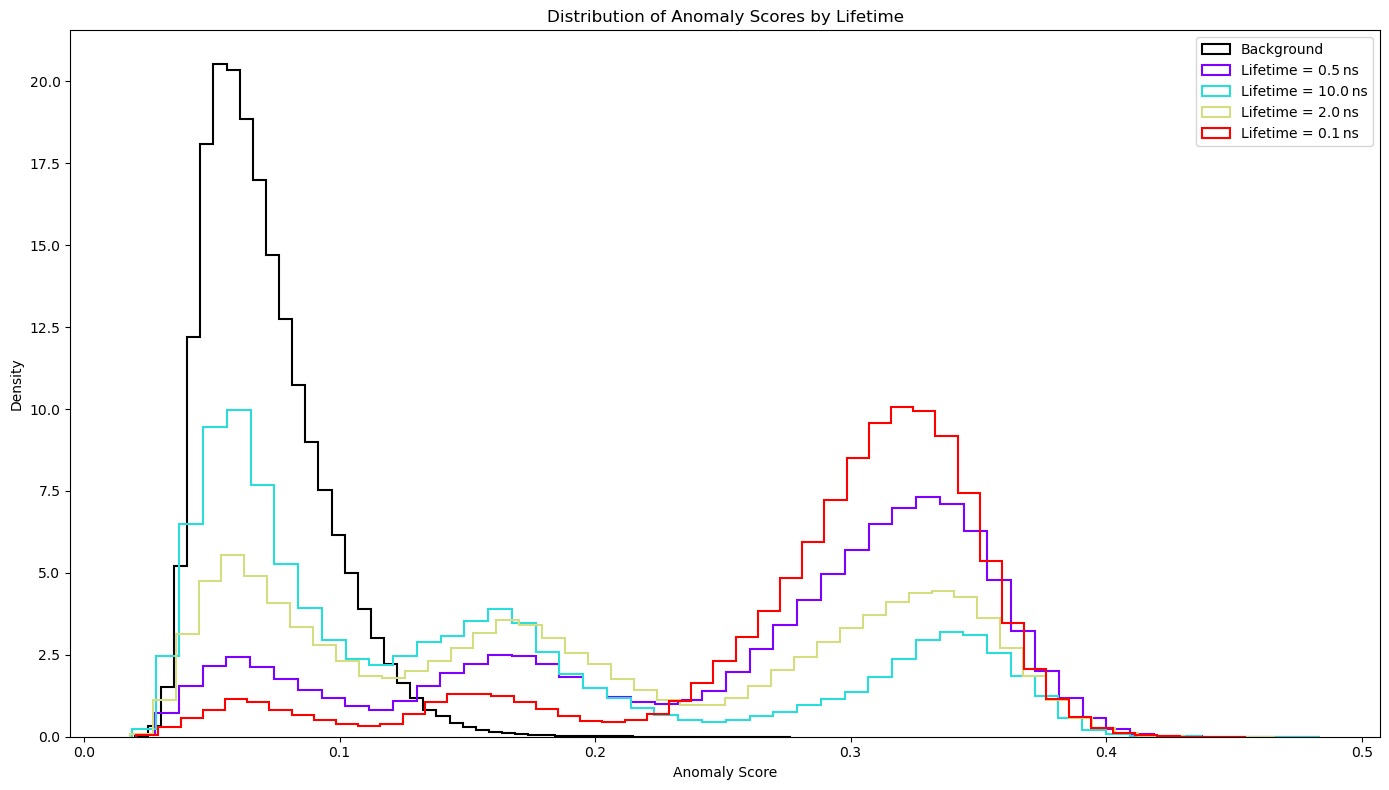

In [15]:
# Group models by lifetime
lifetime_groups = {}
for model_name, results in model_results.items():
    lifetime = results['lifetime']
    if lifetime not in lifetime_groups:
        lifetime_groups[lifetime] = []
    lifetime_groups[lifetime].extend(results['scores'])

plt.figure(figsize=(14, 8))

# background
plt.hist(test_scores,
         bins=50, density=True,
         histtype="step", lw=1.5, color="black",
         label="Background")

# lifetime groups
colors = cm.rainbow(np.linspace(0, 1, len(lifetime_groups)))
for (lifetime, scores), c in zip(lifetime_groups.items(), colors):
    if len(scores) > 10:
        plt.hist(scores,
                 bins=50, density=True,
                 histtype="step", lw=1.5, color=c,
                 label=f"Lifetime = {lifetime} ns")

plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("Distribution of Anomaly Scores by Lifetime")
plt.legend()
plt.tight_layout()
plt.show()


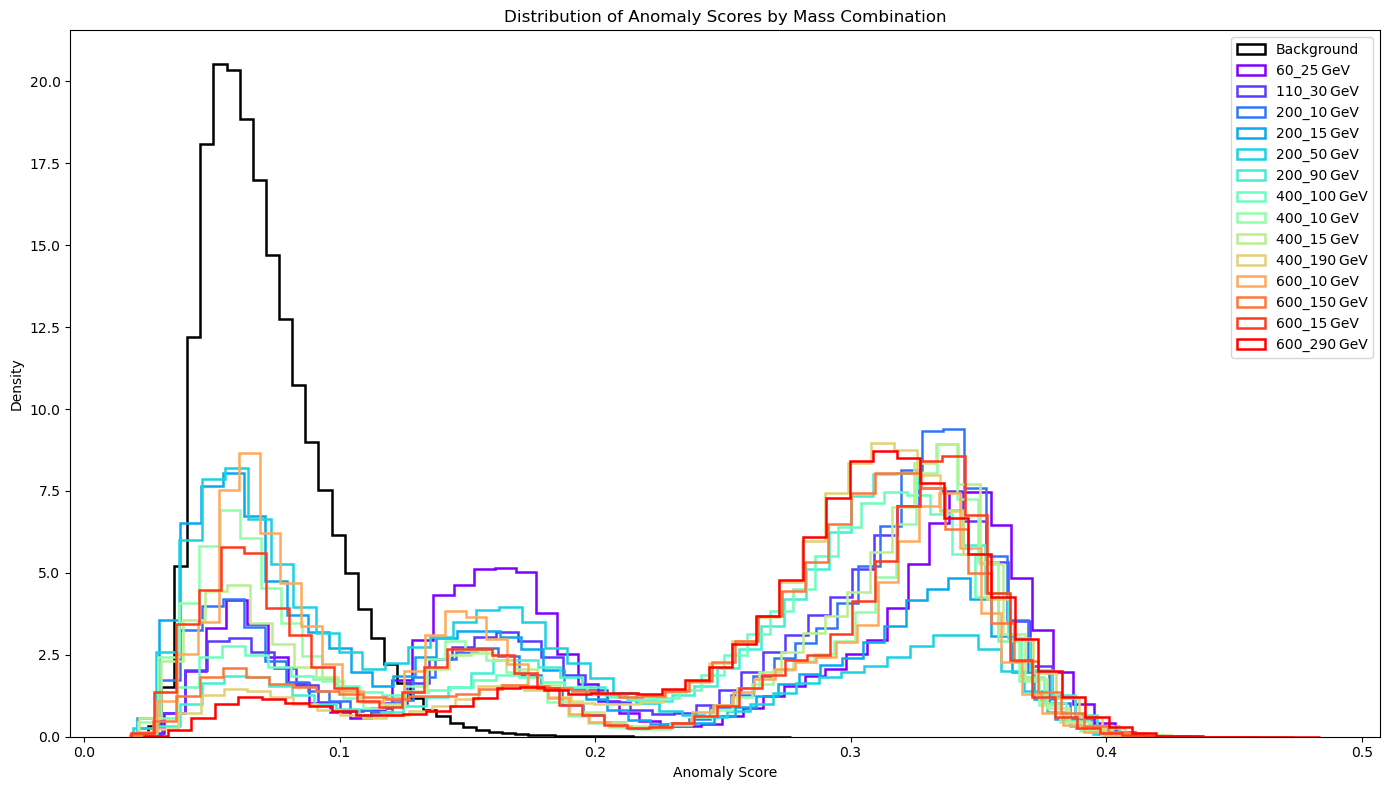

In [16]:
# Group models by mass combination
mass_groups = {}
for model_name, results in model_results.items():
    mass_key = f"{results['mass1']}_{results['mass2']}"
    if mass_key not in mass_groups:
        mass_groups[mass_key] = []
    mass_groups[mass_key].extend(results['scores'])

plt.figure(figsize=(14, 8))

# background outline
plt.hist(test_scores, bins=50, density=True,
         histtype="step", lw=1.8, color="black", label="Background")

# mass‑key outlines
colors = cm.rainbow(np.linspace(0, 1, len(mass_groups)))
for (mass_key, scores), c in zip(mass_groups.items(), colors):
    plt.hist(scores, bins=50, density=True,
             histtype="step", lw=1.8, color=c,
             label=f"{mass_key} GeV")

plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("Distribution of Anomaly Scores by Mass Combination")
plt.legend()
plt.tight_layout()
plt.show()

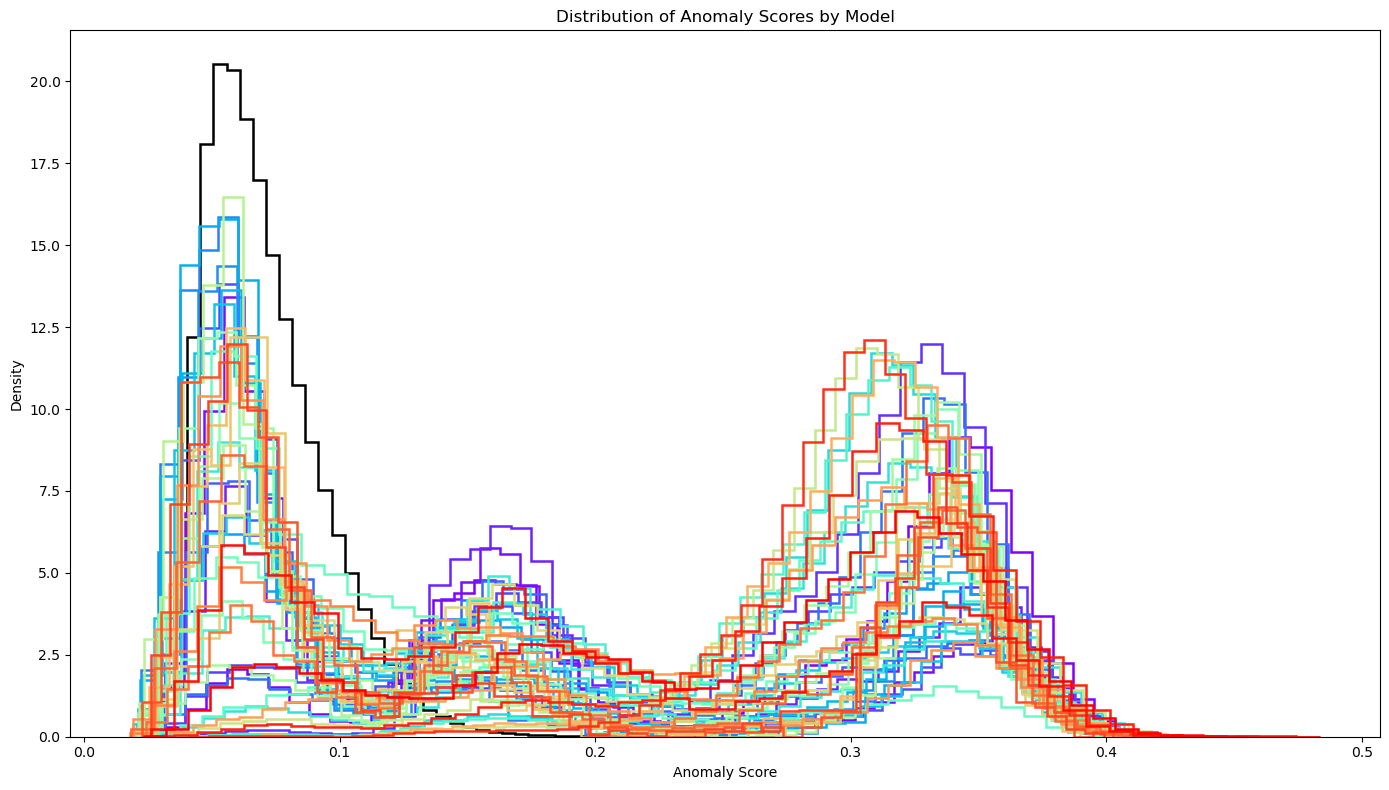

In [17]:
plt.figure(figsize=(14, 8))

# background outline
plt.hist(test_scores, bins=50, density=True,
         histtype="step", lw=1.8, color="black", label="Background")

# model outlines
colors = cm.rainbow(np.linspace(0, 1, len(model_results)))
for (model_name, results), c in zip(model_results.items(), colors):
    plt.hist(results["scores"], bins=50, density=True,
             histtype="step", lw=1.8, color=c,
             label=model_name)

plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("Distribution of Anomaly Scores by Model")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
def calculate_feature_correlations(scores, e_feats, p_feats, method='pearson'):
    """
    Calculate correlations between anomaly scores and each feature.
    
    Parameters:
    -----------
    scores: numpy array of anomaly scores
    e_feats: electron features (shape: [n_events, n_electrons, n_features])
    p_feats: photon features (shape: [n_events, n_photons, n_features])
    method: correlation method ('pearson' or 'spearman')
    
    Returns:
    --------
    Dictionary with correlations for electron and photon features
    """
    results = {
        'electron': [],
        'photon': []
    }
    
    # Define correlation function based on method
    if method == 'pearson':
        corr_func = pearsonr
    else:  # spearman
        corr_func = spearmanr
    
    # Calculate for electron features
    for feat_idx in range(e_feats.shape[2]):
        # Average feature value across all electrons in each event
        feat_values = np.mean(e_feats[:, :, feat_idx], axis=1)
        # Only consider events where feature exists (non-zero)
        mask = ~np.isnan(feat_values) & (np.abs(feat_values) > 1e-10)
        
        if np.sum(mask) > 10:  # Need enough data points
            corr, p_value = corr_func(scores[mask], feat_values[mask])
            results['electron'].append({
                'feature_idx': feat_idx,
                'correlation': corr,
                'p_value': p_value
            })
    
    # Calculate for photon features
    for feat_idx in range(p_feats.shape[2]):
        # Average feature value across all photons in each event
        feat_values = np.mean(p_feats[:, :, feat_idx], axis=1)
        # Only consider events where feature exists (non-zero)
        mask = ~np.isnan(feat_values) & (np.abs(feat_values) > 1e-10)
        
        if np.sum(mask) > 10:  # Need enough data points
            corr, p_value = corr_func(scores[mask], feat_values[mask])
            results['photon'].append({
                'feature_idx': feat_idx,
                'correlation': corr,
                'p_value': p_value
            })
    
    return results

def plot_correlation_results(correlation_results, e_feat_names=None, p_feat_names=None):
    """
    Plot correlation results between scores and features.
    
    Parameters:
    -----------
    correlation_results: Output from calculate_feature_correlations
    e_feat_names: List of electron feature names (optional)
    p_feat_names: List of photon feature names (optional)
    """
    # Prepare data for plotting
    e_corrs = pd.DataFrame(correlation_results['electron'])
    p_corrs = pd.DataFrame(correlation_results['photon'])
    
    # Add feature names if provided
    if e_feat_names:
        e_corrs['feature_name'] = e_corrs['feature_idx'].apply(lambda x: e_feat_names[x])
    else:
        e_corrs['feature_name'] = e_corrs['feature_idx'].apply(lambda x: f"Electron_{x}")
        
    if p_feat_names:
        p_corrs['feature_name'] = p_corrs['feature_idx'].apply(lambda x: p_feat_names[x])
    else:
        p_corrs['feature_name'] = p_corrs['feature_idx'].apply(lambda x: f"Photon_{x}")
    
    # Sort by absolute correlation
    e_corrs['abs_corr'] = np.abs(e_corrs['correlation'])
    p_corrs['abs_corr'] = np.abs(p_corrs['correlation'])
    e_corrs = e_corrs.sort_values('abs_corr', ascending=False)
    p_corrs = p_corrs.sort_values('abs_corr', ascending=False)
    
    # Plot electron correlations
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='feature_name', y='correlation', data=e_corrs)
    plt.title('Correlation Between Anomaly Score and Electron Features')
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('electron_feature_correlations.png', dpi=300)
    plt.show()
    
    # Plot photon correlations
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='feature_name', y='correlation', data=p_corrs)
    plt.title('Correlation Between Anomaly Score and Photon Features')
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('photon_feature_correlations.png', dpi=300)
    plt.show()
    
    # Print top correlations
    print("\nTop electron feature correlations:")
    for _, row in e_corrs.iloc[:10].iterrows():
        print(f"  {row['feature_name']} (idx {row['feature_idx']}): {row['correlation']:.4f} (p={row['p_value']:.4e})")
    
    print("\nTop photon feature correlations:")
    for _, row in p_corrs.iloc[:10].iterrows():
        print(f"  {row['feature_name']} (idx {row['feature_idx']}): {row['correlation']:.4f} (p={row['p_value']:.4e})")
    
    return e_corrs, p_corrs

# Define feature names (from README)
electron_features_list = [
    'electron_pt', 'electron_eta', 'electron_phi',
    'electron_time', 'electron_d0', 'electron_z0', 'electron_dpt',
    'electron_nPIX', 'electron_nMissingLayers', 
    'electron_chi2', 'electron_f1', 'electron_f3', 'electron_z'
]

photon_features_list = [
    'photon_pt', 'photon_eta', 'photon_phi',
    'photon_time', 'photon_maxEcell_E', 'photon_f1', 'photon_f3', 
    'photon_r1', 'photon_r2', 'photon_etas1', 'photon_phis1', 'photon_z'
]

In [ ]:
# Main execution
# 1. Calculate correlations
corr_results = calculate_feature_correlations(all_scores, 
                                             np.concatenate([test_electron_features, signal_electron_features]), 
                                             np.concatenate([test_photon_features, signal_photon_features]), 
                                             method='spearman')

# 2. Plot correlation results
e_corrs, p_corrs = plot_correlation_results(corr_results, 
                                           electron_features_list, 
                                           photon_features_list)

In [ ]:
def plot_electron_pt_distributions(e_feats, background_mask):
    """
    Create 1D histograms of pT for all 4 electrons in background events.
    
    Parameters:
    -----------
    e_feats: Electron features array [events, electrons, features]
    background_mask: Boolean mask for background events
    """
    # PT index in feature arrays
    pt_idx = 1  # Electron pt is at index 1
    
    # Create a figure with 4 subplots (one for each electron)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Flatten for easier indexing
    
    # Plot PT distribution for each electron
    for i in range(4):
        # Extract pt for the i-th electron in each event
        e_pt = e_feats[background_mask, i, pt_idx]
        
        # Filter out events where this electron doesn't exist (energy = 0)
        valid_mask = e_feats[background_mask, i, 0] > 0  # Energy > 0
        valid_e_pt = e_pt[valid_mask]
        
        # Only plot if we have enough data points
        if len(valid_e_pt) > 10:
            # Plot histogram
            axes[i].hist(valid_e_pt, bins=50, alpha=0.75, color='blue')
            
            # Calculate and show basic statistics
            mean_pt = np.mean(valid_e_pt)
            median_pt = np.median(valid_e_pt)
            std_pt = np.std(valid_e_pt)
            
            # Electron label based on index
            if i == 0:
                electron_label = "Leading Electron"
            elif i == 1:
                electron_label = "Sub-leading Electron"
            elif i == 2:
                electron_label = "Third Electron"
            else:
                electron_label = "Fourth Electron"
                
            axes[i].set_xlabel('Transverse Momentum (pT)')
            axes[i].set_ylabel('Count')
            axes[i].set_title(f'{electron_label} pT Distribution\nMean: {mean_pt:.2f}, Median: {median_pt:.2f}, Std: {std_pt:.2f}')
            axes[i].grid(alpha=0.3)
            
            # Add count of valid events
            axes[i].text(0.95, 0.95, f'Events: {len(valid_e_pt)}',
                       transform=axes[i].transAxes, 
                       horizontalalignment='right',
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            
            # Optional: set log scale for y-axis
            axes[i].set_yscale('log')
        else:
            axes[i].text(0.5, 0.5, "Insufficient data", 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[i].transAxes)
    
    plt.tight_layout()
    plt.savefig('electron_pt_distributions.png', dpi=300)
    plt.show()

# Call the function
background_mask = all_labels == 0  # Get only background events

plot_electron_pt_distributions(
    np.concatenate([test_electron_features, signal_electron_features]),
    background_mask
)